<a id="0"></a> <br>

 ## Table of Contents  

- [Imports](#1)
- [Read Data](#2)
- [All Users](#7)
    - [Data Processing](#3)
    - [Clustering](#4)
        - [Find Number of Clusters](#5)
        - [Analysis of Clusters](#6)
    - [Feature Importance](#13)
- [FTD Only](#8)
    - [Data Processing](#9)
    - [Clustering](#10)
        - [Find Number of Clusters](#11)
        - [Analysis of Clusters](#12)
        
    - [Feature Importance](#14)

<a id="1"></a> 

### Imports

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

<a id="2"></a>

### Read Data

In [80]:
query_1 = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/query_1.csv')
query_1 = query_1.dropna(subset='coupon_signup_id') # one nan in this column which was stopping the left join
query_1['coupon_signup_id'] = query_1['coupon_signup_id'].astype('Int64')
query_2 = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/query_2.csv')
query_3 = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/query_3.csv')
query_5 = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/query_5.csv')
query_5 = query_5.rename(columns={'id':'coupon_id'})
query_6 = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/query_6.csv')
query_7 = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/fda_data.csv')

In [81]:
df_raw = pd.merge(query_1, query_2, how='left', left_on='id', right_on = 'username_id')
df_raw = pd.merge(df_raw, query_3, how='left', on='username')
df_raw = pd.merge(df_raw, query_5[['coupon_id','coupon_designation']], how='left', left_on='coupon_signup_id', right_on = 'coupon_id')
df_raw = pd.merge(df_raw, query_6, how='left', left_on='id', right_on = 'id')

In [82]:
df_ftd = df_raw[df_raw['is_ftd'] == True]

<a id="7"></a>

# All Users

<a id="3"></a>

## Data Processing

In [83]:
cat_data = ['is_ftd', 'is_limited', 'sign_up_time', 'result', 'coupon_designation']

In [84]:
def preprocessing(df_sub):
    
    # drop columns
    cols2rem = ['id', 'username_x', 'experience_level', 'created_est', 'coupon_signup_id', 'customer_id', 'dob', 'username_id', 'coupon_id', 'username_y']

    df = df_sub.drop(cols2rem, axis = 1)
    
    # clean the  data 

    # fill nans from non ftds
    df = df.fillna(0)

    # convert dates into hours
    df.max_contest_created = (datetime.now() - pd.to_datetime(df.max_contest_created)).dt.total_seconds() / 3600
    df.max_pick_date_diff = pd.to_timedelta(df.max_pick_date_diff).dt.total_seconds() / 3600
    df.av_pick_date_diff = pd.to_timedelta(df.av_pick_date_diff).dt.total_seconds() / 3600
    
    df_pre_encoding = df # for analysis later
    
    # encode the categorical data

    df = pd.get_dummies(df, columns=cat_data, prefix=cat_data)
    
    # normalise numerical data
    num_data = df.columns[:18]

    min_max = MinMaxScaler()
    df[num_data] = min_max.fit_transform(df[num_data])
    
    return df, df_pre_encoding, num_data

In [174]:
df, df_pre_encoding, num_data = preprocessing(df_raw)

<a id="4"></a>

# Clustering

<a id="5"></a>


### Find Number of Clusters

In [44]:
def find_num_clusters(df, start, end):
    cluster_inertia = []

    for i in range(int(start),int(end)):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10) 
        kmeans.fit(df)
        cluster_inertia.append(kmeans.inertia_)


    plt.plot(range(int(start),int(end)), cluster_inertia)
    plt.ylabel("Metric for Effectiveness Clustering")
    plt.xlabel("Number of Clusters")
    plt.title("Change in Effectiveness of Clustering Based on Number of Clusters")
    plt.show()

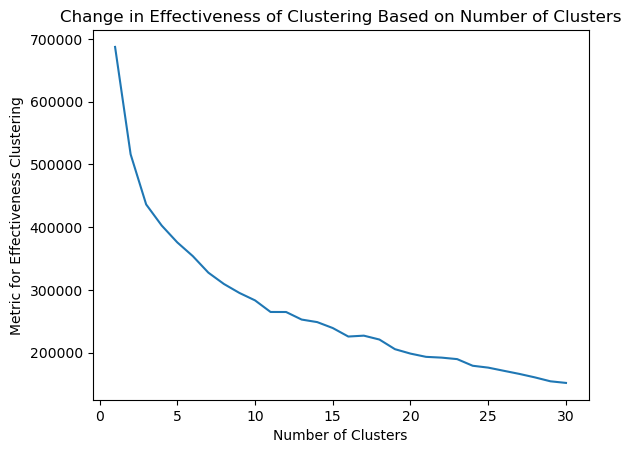

In [22]:
find_num_clusters(df, 1, 31)

We see ideal number of clusters is between 12-16.

<a id="6"></a>

### Analysis of Clusters

In [178]:
# Analysis of k means

def cluster_analysis(n_clusters, df_cluster_pre_encoding):

    cluster_data_dict = {}

    for label in list(df_cluster_pre_encoding[n_clusters].unique()):
        each_cluster_dict = {}

        df_per_cluster = df_cluster_pre_encoding[df_cluster_pre_encoding[n_clusters] == label]   

        for col in num_data:
            col_mean = df_per_cluster[col].mean()
            each_cluster_dict[col] = col_mean

            
        for col in cat_data:
            col_most_freq = pd.Series(df_per_cluster[col]).mode().values[0]      
            each_cluster_dict[col] = col_most_freq

        cluster_data_dict[label] = each_cluster_dict

    return cluster_data_dict

In [189]:
def n_cluster_analysis(df_arbitary, df_pre_encoding_arbitary, start, end):
    
    df_cluster_pre_encoding = df_pre_encoding_arbitary
    n_clusters_summary = {}
    n_clusters_all = {}
        
    for i in range(int(start),int(end)):
        
        kmeans_cluster = KMeans(n_clusters = i, n_init = 10)
        kmeans_cluster.fit(df_arbitary)
        
        
        title = 'Label_{}_clusters'.format(i)
        
        df_cluster_pre_encoding[title] = kmeans_cluster.predict(df_arbitary)
        
        
        n_clusters_all[i] = df_cluster_pre_encoding
        
        n_clusters_summary[i] = pd.DataFrame(cluster_analysis(title, df_cluster_pre_encoding)).T
            
               
        print("{} clusters finished".format(i))
        
    
        
    return n_clusters_summary, n_clusters_all

In [199]:
all_cluster_summary_dict, all_cluster_all_dict = n_cluster_analysis(df, df_pre_encoding, 12, 17)

12 clusters finished
13 clusters finished
14 clusters finished
15 clusters finished
16 clusters finished


<a id="13"></a>

## Feature Importance

In [181]:
def binary_label(x, cluster):
    if x == cluster:
        return 1
    else: 
        return 0

In [182]:
def feature_importance(X, y):
    
    cluster_important_feat = {}
    
    for cluster in range(len(np.unique(y))):
        y_bin = pd.Series(y).apply(lambda x: binary_label(x,cluster))
        clf = RandomForestClassifier(random_state=0)
        clf.fit(X, y_bin)
        top_5_features = list(X.columns[clf.feature_importances_.argsort()[-5:][::-1]])    
        cluster_important_feat[cluster] = top_5_features
    return cluster_important_feat

In [183]:
def n_cluster_features(df, df_pre_encoding, start, end):
    
    X = df
    
    all_clusters = {}

    for i in range(int(start),int(end)):
        
        title = 'Label_{}_clusters'.format(i)
        y = df_pre_encoding[title].to_numpy().squeeze()
        
        all_clusters[i] = feature_importance(X, y)
        
    return all_clusters

In [200]:
all_clusters_features = n_cluster_features(df, df_pre_encoding, 12, 17)

<a id="8"></a>

# FTD Only

<a id="9"></a>

## Data Processing

In [195]:
df_ftd, df_ftd_pre_encoding, num_data_ftd = preprocessing(df_ftd)

<a id="10"></a>

## Clustering

<a id="11"></a>

### Finding Number of Clusters

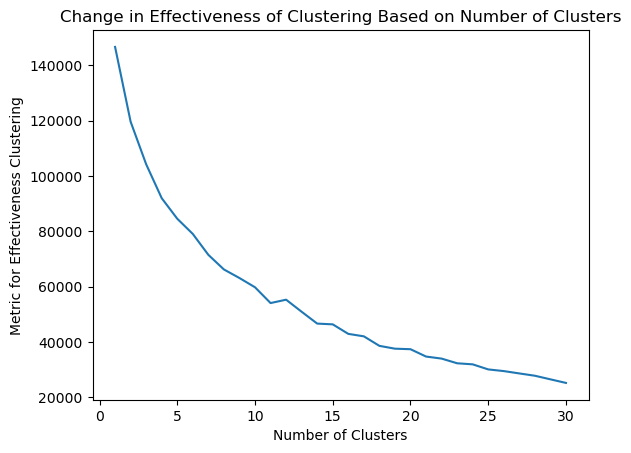

In [65]:
find_num_clusters(df_ftd, 1, 31)

We see the ideal number of clusters is 13-17

<a id="12"></a>

### Analysis of Clusters

In [196]:
ftd_cluster_summary_dict, ftd_cluster_all_dict = n_cluster_analysis(df_ftd, df_ftd_pre_encoding, 13, 17)

13 clusters finished
14 clusters finished
15 clusters finished
16 clusters finished


<a id="13"></a>

## Feature Importance

In [198]:
ftd_clusters_features = n_cluster_features(df_ftd, df_ftd_pre_encoding, 13, 17)